In [1]:
import sys
import pylab as plb
import numpy as np
import mountaincar

In [95]:
class DummyAgent():
    """A not so good agent for the mountain-car task.
    """

    def __init__(self, mountain_car = None, x_linspace = (-150, 30, 20),
                v_linspace = (-15, 15, 20), w = None, tau = 1, gamma = 0.95,
                 eta = 0.0001, lambda_ = 0.95):
        ''' Initialize the object '''
        
        # saving the environment object
        if mountain_car is None:
            self.mountain_car = mountaincar.MountainCar()
        else:
            self.mountain_car = mountain_car
        
        # range for x neurons grid
        self.x_values = np.linspace(*x_linspace)

        # range for v neurons grid
        self.v_values = np.linspace(*v_linspace)

        # steps x and v
        self.delta_x = self.x_values[1] - self.x_values[0]
        self.delta_v = self.v_values[1] - self.v_values[0]

        # sigmas x and v
        self.sigma_x = np.array([self.delta_x] * len(self.x_values))
        self.sigma_v = np.array([self.delta_v] * len(self.v_values))

        # number of actions
        self.n_actions = 3

        # number of neurons
        self.n_neurons = len(self.x_values) * len(self.v_values)

        # weight matrix
        if w is None:
            #self.w = np.random.randn(self.n_actions, self.n_neurons)
            self.w = np.zeros((self.n_actions, self.n_neurons))
        else:
            self.w = w

        # sampling softmax temperature
        self.tau = tau
        
        # reward discount factor
        self.gamma = gamma
        
        # learning rate
        self.eta = eta
        
        # eligibility trace parameter
        self.lambda_ = lambda_
            
    def r(self, x, v):
        ''' get neuron activations for s = (x, v) '''
        # x in rows, v in columns
        part_x = np.reshape(np.divide((self.x_values - x) ** 2, self.sigma_x ** 2), (-1, 1))
        part_v = np.reshape(np.divide((self.v_values - v) ** 2, self.sigma_v ** 2), (1, -1))
        return np.exp(-(part_x + part_v))

    def get_Q(self, x, v):
        ''' Get Q-function at given s = (x, v) with weights w '''
        
        return np.reshape(self.w @ np.reshape(self.r(x, v), (-1, 1)), (-1,))

    def get_action_probas(self, Q):
        ''' get action probabilities as a vector '''

        vector = np.exp(Q / self.tau)
        ret = vector / np.sum(vector)
        if not(0.9999 <= sum(ret) <= 1.00001):
            print("Probability does not sum up! They're: {}, with sum {}".format(ret,sum(ret)))
        return vector / np.sum(vector)

    def get_action_index(self, x, v):
        ''' Sample action for s = (x, v) and weights w with parameter tau '''

        Q = self.get_Q(x, v)
        action_probas = self.get_action_probas(Q)
        return np.random.choice(range(self.n_actions), p = action_probas)

    def update_w(self, x, v, a_index, delta):
        ''' Perform gradient descent on Q(s, a) by delta given s and a'''
        
        dQ_dwa = np.reshape(self.r(x, v), -1)
        self.w[a_index, :] += delta * dQ_dwa

    def visualize_trial(self, n_steps = 200):
        """Do a trial without learning, with display.

        Parameters
        ----------
        n_steps -- number of steps to simulate for
        """
        
        # prepare for the visualization
        plb.ion()
        mv = mountaincar.MountainCarViewer(self.mountain_car)
        mv.create_figure(n_steps, n_steps)
        plb.draw()
        plb.pause(1e-3)
            
        # make sure the mountain-car is reset
        self.mountain_car.reset()
        
        for n in (range(n_steps)):
            print('\rt =', self.mountain_car.t)
            sys.stdout.flush()
            
            # get current state
            s = (self.mountain_car.x, self.mountain_car.x_d)

            # selection current action based on softmax
            action_index = self.get_action_index(*s)
            
            # perform the action
            self.mountain_car.apply_force(action_index - 1)
            
            # simulate the timestep
            self.mountain_car.simulate_timesteps(100, 0.01)

            # update the visualization
            mv.update_figure()
            plb.draw()
            plb.pause(1e-3)
            
            # check for rewards
            if self.mountain_car.R > 0.0:
                print("\rreward obtained at t = ", self.mountain_car.t)
                break

    def learn(self, max_steps = 1500):
        """Do a trial without learning, with display.

        Parameters
        ----------
        n_steps -- number of steps to simulate for
        """
            
        # make sure the mountain-car is reset
        self.mountain_car.reset()

        # saved previous state
        old_s = None
        old_a = None
        
        # all states and actions array
        all_s_a = []
        
        # is finished
        finished = False
        
        time = 0
        
        for n in (range(max_steps)):
            # get current state
            s = (self.mountain_car.x, self.mountain_car.x_d)
            #print("state is {}".format(s))
            
            #print('\rt =', s, self.mountain_car.t, self.get_action_index(*s))
            sys.stdout.flush()

            # selection current action based on softmax
            action_index = self.get_action_index(*s)
            #print("action_index is {}".format(action_index))

            # save all past s, a
            all_s_a.append((s, action_index))
            #print("all_s_a is {}".format(all_s_a))
            
            # perform the action
            self.mountain_car.apply_force(action_index - 1)
            
            # simulate the timestep
            self.mountain_car.simulate_timesteps(100, 0.01)
            
            # check for rewards (runs at the end once)
            if self.mountain_car.R > 0.0:
                # print the obtained reward
                #print(len(all_s_a))
                time += len(all_s_a) #Update escape latency time
                #print("\rreward obtained at t = ", self.mountain_car.t)
                
                # compute vector [xi ^ (T-1), ..., 1] where xi = gamma * lambda
                eligibility_trace = np.flip(np.array([self.gamma * self.lambda_]) **
                                            np.arange(len(all_s_a)), axis = 0)
                
                # compute the update for the Q function
                # update = eta * delta (from lectures)
                
                # old Q
                Q = self.get_Q(*old_s)[old_a]
                
                # new Q
                Q1 = np.max(self.get_Q(*s))
                
                # eta * (R + gamma * Qnew - Qold)
                update = self.eta * (self.mountain_car.R + self.gamma * Q1 - Q)
                
                # loop over history
                i = 0
                
                for s0, a0 in all_s_a:
                    #print("states and actions are {},{}".format(s0, a0))
                    #print("elig. trace is {}".format(eligibility_trace[i]))
                    #print("i is {}".format(i))
                    # updating weights with SARSA(\lambda) algortihm
                    self.update_w(s0[0], s0[1], a0, update * eligibility_trace[i])
                    i += 1
                    
                # no steps after the reward
                finished = True
                break
                
            # saving old state
            old_s = s
            old_a = action_index
        #if not finished:
            #print('No reward :( ')
            
        return time, all_s_a
    
    def get_action_field(self,x_range,v_range):
        """Gets action vector field for each trial
            using all 180 values for x \in [-150,30] and
            30 values for \dot(x) \in [-15,15]"""
        
        states = np.zeros((len(x_range),len(v_range)),dtype=tuple)
        for i in range(len(x_range)):
            for j in range(len(v_range)):
                states[i,j] = (x_range[i],v_range[j])
        
        #states_x, states_y = np.meshgrid(x_range,v_range)
                
        action_fields =  np.zeros((len(x_range),len(v_range)))
        for i in range(states.shape[0]):
            for j in range(states.shape[1]):
                #print(states[i,j])
                action_fields[i,j] = self.get_action_index(*states[i,j]) - 1
        #action_fields_x = self.get_action_index(states_x,states_y) - 1
        #action_fields_y = self.get_action_index(states_y) - 1
        
        #return states_x,states_y, action_fields_x, action_fields_y
        
        return action_fields
                

lambda is 0.0
tau is 0.0001
[ 310.   373.9  256.5  368.5  458.6  325.4  430.6  364.3  357.4  514.7
  448.2  686.7  397.9  284.5  510.   160.9  325.8  490.7  250.3  291.2
  262.3  376.9  348.5   91.5  362.2  643.3  307.3  108.8  465.1  395.7
  524.3  264.7  470.7  685.3  438.9  319.4  270.4  533.4  262.2  458.2
  365.9  635.7  596.7  377.5  569.5  468.6  339.8  324.1  263.3  281.9] (50,) agent averaged esacpe latency times
tau is 100000.0
[ 360.2  261.8  413.8   77.1  705.2  387.4  199.8  208.6  237.5  577.1
  384.1  412.6  524.7  409.3  135.1  151.3  871.3  374.4  272.7  667.7
  155.5  224.7  271.2  256.4  487.8  226.4  525.6  378.   335.3  594.7
  536.6  518.2  154.7  601.8  485.   474.8  474.1  216.5  533.9  283.6
  363.3  254.7  275.    90.8  392.   438.5  359.   239.8  310.7  568.6] (50,) agent averaged esacpe latency times


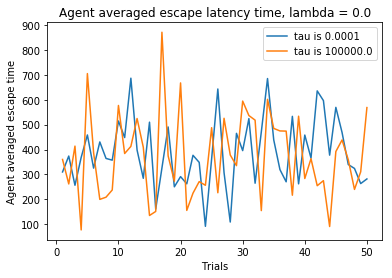

lambda is 0.95
tau is 0.0001
[ 133.3  622.7  625.8  524.2  397.7  210.3  546.7  962.8  350.7  646.5
  156.5  621.4  503.8  218.4  421.2  559.5  353.6  320.4  348.2  221.7
  546.2  587.3  349.1  328.5  330.6  330.3  488.6  450.7  227.7  406.
  373.6  297.5  334.3  276.3  423.   449.2  239.1  460.4  383.   281.2
  182.5  311.6  247.1  331.   207.2  592.7  134.3  257.7  278.5  293.1] (50,) agent averaged esacpe latency times
tau is 100000.0
[ 315.4  409.9  549.3  595.4  463.4  368.   617.3  477.4  489.   436.5
  270.8  167.7  507.6  599.3  435.2  524.8  250.7  495.   355.1  335.2
  301.5  279.   286.5  735.3  386.4  332.1  248.1  440.   223.4  397.6
  496.5  753.6  174.7  230.7  508.7  206.5  462.8  147.6  258.   633.
  593.2  260.2  434.9  697.7  470.2  661.1  466.2  451.9  275.3  366.4] (50,) agent averaged esacpe latency times


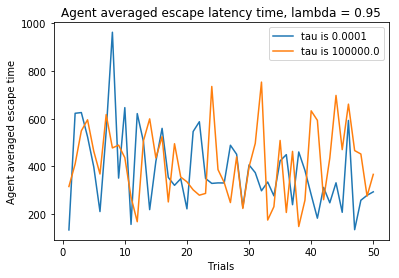

In [102]:
import matplotlib.pyplot as plt
av_times = {} #Dictionary for agent averaged times

def get_escape_rate(t=0.0001,et=0.0001,lam = 0.95, num_ags=10,its=100,plot_field=True):
    """Gets agent averaged escape times for given tau and lambda
        If plot_field = True, plots the action fields for three trials"""

    times = np.zeros((num_ags,its))
    #times_non_zero = np.zeros((num_ags))
    for i in range(num_ags):
        d = DummyAgent(tau = t,eta = et,lambda_ = lam)

        # learn for 100 iterations
        j_print = np.asarray([0,int(its/2),its - 1]) #Values to print Q field
        for j in range(its):
            time, hists = d.learn()
            times[i,j] = time
        
            x_range = np.linspace(-150,30,10)
            v_range = np.linspace(-30,30,10)
            if plot_field:
                if any(x==j for x in j_print):
                    if i == 0: #For the first agent
                        fields = d.get_action_field(x_range,v_range)
                        y_comp = np.zeros((len(x_range),len(v_range)))
                        states_x, states_y = np.meshgrid(x_range,v_range)
                    plt.figure()
                    plt.title("Action field of agent 1, at iteration {}".format(j))
                    Q = plt.quiver(states_x,states_y,fields,y_comp,units="dots",color='r')
                    plt.xlabel("x")
                    plt.ylabel(r'$\dot{x}$')
                    qk = plt.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E', coordinates='figure')
                    plt.show()
        
        #print(times[i,:][np.nonzero(times[i,:])])
        #times_non_zero[i] = times[i,:][np.nonzero(times[i,:])]
    
    av_times = np.mean(times,axis=0)
    #av_times_nonzero = np.mean(times_non_zero,axis=0)
    print(av_times,av_times.shape,"agent averaged esacpe latency times")

    return av_times

def explore_taus_lambdas():
    #taus = [0.00001,1.,1000000.]
    taus = [0.0001,100000.]
    #lambdas = [0.95]
    lambdas = [0.,0.95]

    iters = 50
    for l in lambdas:
        print("lambda is {}".format(l))
        av_times[l] = {}
        plt.figure()
        for tau in taus:
            print("tau is {}".format(tau))
            av_times[l][tau] = get_escape_rate(t=tau,lam=l,its=iters,plot_field=False)
        plt.plot(np.linspace(1,iters,iters),av_times[l][taus[0]],label="tau is {}".format(taus[0]))
        plt.plot(np.linspace(1,iters,iters),av_times[l][taus[1]],label="tau is {}".format(taus[1]))
        #plt.plot(np.linspace(1,its,its),av_times[l][taus[2]],label="tau is {}".format(taus[2]))
        plt.title("Agent averaged escape latency time, lambda = {}".format(l))
        plt.xlabel("Trials")
        plt.ylabel("Agent averaged escape time")
        plt.legend()
        plt.show()
        
explore_taus_lambdas()

lambda is 0.95
eta is 1e-05
[  53.1  655.1  345.8  608.9  138.3  377.5  685.5  538.9  562.2  465.3
  438.1  205.2  496.3  483.9  262.8  443.4  256.7  462.8  223.1  836.1
  406.5  428.5  445.5  451.4  468.6  402.   418.9  694.7  514.2  380.3
  232.8  500.4  497.   251.   522.5  381.2  557.7  312.2  573.2  572.
  400.8  311.1  394.   653.3  754.9  566.5  553.8  518.1  201.5  448.7
  634.4  369.1  401.   592.2  599.6  925.5  509.6  661.4  649.7  380.8
  529.4  238.7  631.6  467.6  452.4  471.7  305.1  526.5  509.8  304.4
  469.1  483.4  418.   388.8  389.3  451.   499.3  385.3  307.9  404.1
  319.1  468.5  312.3  438.3  412.2  442.2  583.5  463.5  466.1  472.8
  755.8  393.1  477.3  345.6  450.6  558.9  458.9  457.8  589.8  311.9] (100,) agent averaged esacpe latency times
eta is 2e-05
[ 536.9  464.4  420.3  249.8  238.6  557.6  603.1  472.7  386.4  435.3
  620.5  415.8  582.2  470.7  715.2  166.2  742.3  615.9  438.3  507.6
  434.8  568.2  490.9  355.9  284.9  727.7  376.4  798.7  296.6 

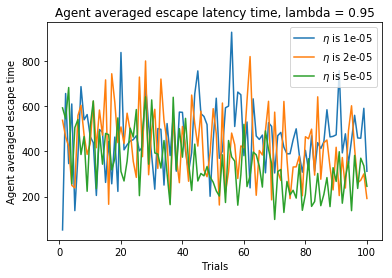

In [104]:
times_opt = {}
def optimise_eta():
    tau = 0.0001 #For one value of tau and lambda
    lambdas = [0.95]
    #ets = [0.0001,0.0002,0.0005] #For 0.001 probs don't add to one!!
    ets = [0.00001,0.00002,0.00005]

    iters = 100
    for l in lambdas:
        print("lambda is {}".format(l))
        times_opt[l] = {}
        plt.figure()
        for e in ets:
            print("eta is {}".format(e))
            times_opt[l][e] = get_escape_rate(t=tau,et=e,lam=l,its=iters,plot_field=False)
        plt.plot(np.linspace(1,iters,iters),times_opt[l][ets[0]],label=r'$\eta$ is {}'.format(ets[0]))
        plt.plot(np.linspace(1,iters,iters),times_opt[l][ets[1]],label=r'$\eta$ is {}'.format(ets[1]))
        plt.plot(np.linspace(1,iters,iters),times_opt[l][ets[2]],label=r'$\eta$ is {}'.format(ets[2]))
        plt.title("Agent averaged escape latency time, lambda = {}".format(l))
        plt.xlabel("Trials")
        plt.ylabel("Agent averaged escape time")
        plt.legend()
        plt.show()
        
optimise_eta()

In [ ]:

def optimise_eta_trialaveraged(lambdas,etas,iters=50,tau=0.0001):
    """Plots trail and agent averaged escape times vs. eta for different lambdas"""
    times_opt_av = {}
    for l in lambdas:
        print("lambda is {}".format(l))
        times_opt_av[l] = []
        plt.figure()
        for e in ets:
            print("eta is {}".format(e))
            times = get_escape_rate(t=tau,et=e,lam=l,its=iters,plot_field=False)
            times_opt_av[l].append(np.mean(times))
    
    return times_opt_av       
        
#ets = [0.00001,0.00002,0.00005,0.0001,0.0002,0.0005,0.0003]
#lambdas = [0.1,0.3,0.5,0.7,0.9,0.999]
#iters=100
ets = [0.00001,0.00005,0.0001,0.0003]
lambdas = [0.1,0.5,0.7,0.999]
its = 50
times_opt_av = optimise_eta_trialaveraged(lambdas,ets,iters=its)

plt.figure()
plt.plot(ets,times_opt_av[lambdas[0]],label=r'$\lambda$ is {}'.format(lambdas[0]))
plt.plot(ets,times_opt_av[lambdas[1]],label=r'$\lambda$ is {}'.format(lambdas[1]))
plt.plot(ets,times_opt_av[lambdas[2]],label=r'$\lambda$ is {}'.format(lambdas[2]))
plt.plot(ets,times_opt_av[lambdas[3]],label=r'$\lambda$ is {}'.format(lambdas[3]))
plt.title("Agent and trial averaged escape latency vs. eta")
plt.xlabel(r'$\eta$')
plt.ylabel("Averaged escape time - 50 trials, 10 agents")
plt.legend()
plt.show()

lambda is 0.1
eta is 1e-05
[ 331.   452.8  410.2  459.4  179.8  426.4  312.7  489.   628.2  187.4
  616.9  169.   265.7  485.3  300.7  184.   526.3  127.5  369.9  419.7
  363.8  564.4  572.6   88.4  418.7  323.7  414.7  550.2  368.1  110.5
  274.   347.5   20.   455.1  362.9  751.6  362.9  249.5  521.4  381.   639.
  268.1  518.1  530.6  279.7  379.1  618.3  105.3  314.3  319.2] (50,) agent averaged esacpe latency times
eta is 5e-05
[ 227.3  409.4  136.7  540.1  191.4  323.4  709.1  376.6  229.4  141.8
  526.7  383.2  386.7  700.   744.   463.5  400.1  439.3  310.3  305.2
  268.2  365.3  447.4  493.6  259.3  469.   101.2  392.2  329.3  406.   455.
   44.4  509.   241.4  398.2  491.6  139.9  726.6  194.2  428.2  406.6
  155.   510.5  293.4  383.8  406.5  475.9  407.4  737.5    0. ] (50,) agent averaged esacpe latency times
eta is 0.0001
[ 307.3  390.1  318.3  413.2  546.6  410.7  183.9  218.2  544.   355.5
  790.9  360.   421.9  661.4  555.7  220.5  467.5  531.5  410.8  331.8
  442.9  3

t = 0.0
t = 1.0
t = 2.0
t = 3.0
t = 4.0
t = 5.0
t = 6.0
t = 7.0
t = 8.0
t = 9.0
t = 10.0
t = 11.0
t = 12.0
t = 13.0
t = 14.0
t = 15.0
t = 16.0
t = 17.0
t = 18.0
t = 19.0
t = 20.0
t = 21.0
t = 22.0
t = 23.0
t = 24.0
t = 25.0
t = 26.0
t = 27.0
t = 28.0
t = 29.0
t = 30.0
t = 31.0
t = 32.0
t = 33.0
t = 34.0
t = 35.0
t = 36.0
t = 37.0
t = 38.0
t = 39.0
t = 40.0
t = 41.0
t = 42.0
t = 43.0
t = 44.0
t = 45.0
t = 46.0
t = 47.0
t = 48.0
t = 49.0
t = 50.0
t = 51.0
t = 52.0
t = 53.0
t = 54.0
t = 55.0
t = 56.0
t = 57.0
t = 58.0
t = 59.0
t = 60.0
t = 61.0
t = 62.0
t = 63.0
t = 64.0
t = 65.0
t = 66.0
t = 67.0
t = 68.0
t = 69.0
t = 70.0
t = 71.0
t = 72.0
t = 73.0
t = 74.0
t = 75.0
t = 76.0
t = 77.0
t = 78.0
t = 79.0
t = 80.0
t = 81.0
t = 82.0
t = 83.0
t = 84.0
t = 85.0
t = 86.0
t = 87.0
t = 88.0
t = 89.0
t = 90.0
t = 91.0
t = 92.0
t = 93.0
t = 94.0
t = 95.0
t = 96.0
t = 97.0
t = 98.0
t = 99.0
t = 100.0
t = 101.0
t = 102.0
t = 103.0
t = 104.0
t = 105.0
t = 106.0
t = 107.0
t = 108.0
t = 109.0
t = 110.0


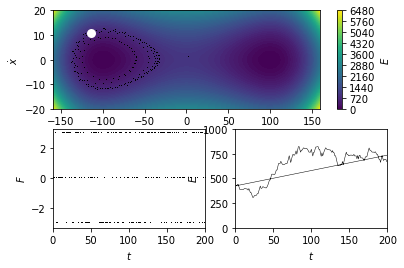

In [14]:
d.visualize_trial()